<a href="https://colab.research.google.com/github/LeoD-h/Spatial/blob/main/SPATIAL_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install ultralytics opencv-python matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.5 MB/s eta 0:00:00


In [3]:
import cv2
import matplotlib.pyplot as plt

!wget -O sky.jpg https://www.shutterstock.com/shutterstock/videos/3479654347/thumb/1.jpg?ip=x480


--2025-12-20 23:35:48--  https://www.shutterstock.com/shutterstock/videos/3479654347/thumb/1.jpg?ip=x480
Resolving www.shutterstock.com (www.shutterstock.com)... 3.167.138.86, 3.167.138.37, 3.167.138.112, ...
Connecting to www.shutterstock.com (www.shutterstock.com)|3.167.138.86|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32609 (32K) [image/jpeg]
Saving to: ‘sky.jpg’

sky.jpg             100%[===================>]  31.84K  --.-KB/s    in 0.001s  

2025-12-20 23:35:48 (40.5 MB/s) - ‘sky.jpg’ saved [32609/32609]



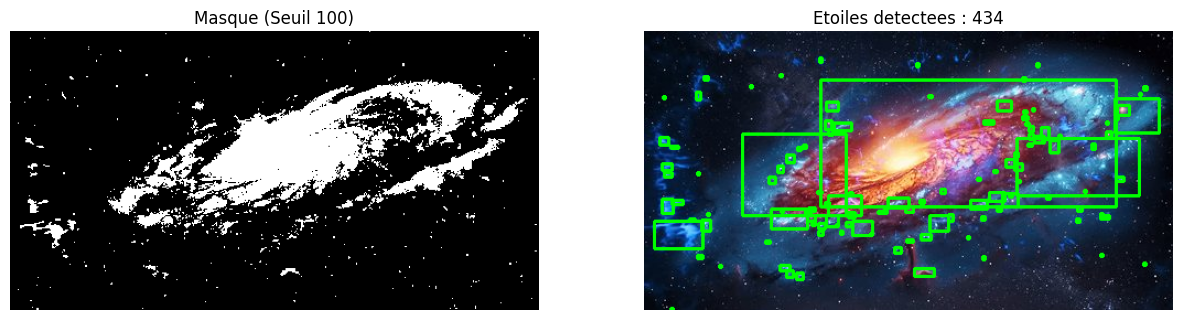

In [ ]:
img = cv2.imread('sky.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

_, thresh = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY)

contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

output = img_rgb.copy()
for cnt in contours:
    if cv2.contourArea(cnt) > 0.5:
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 2)

plt.figure(figsize=(15, 8))

plt.subplot(1, 2, 1)
plt.title(f"Masque (Seuil 100)")
plt.imshow(thresh, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title(f"Etoiles detectees : {len(contours)}")
plt.imshow(output)
plt.axis('off')

plt.show()

In [ ]:
for i, cnt in enumerate(contours):
  if cv2.contourArea(cnt) > 0.5:
        x, y, w, h = cv2.boundingRect(cnt)

        # Découper l'étoile (Crop)
        vignette = img_rgb[y:y+h, x:x+w]

        # C'est ici qu'on peut envoyer 'vignette' à YOLO
        # results = model(vignette)

        # Pour l'instant, on peut juste compter et classer par taille
        print(f"Étoile n°{i} - Position: ({x},{y}) - Taille: {w}x{h} pixels")

Étoile n°3 - Position: (24,251) - Taille: 2x2 pixels
Étoile n°38 - Position: (138,219) - Taille: 6x6 pixels
Étoile n°40 - Position: (129,217) - Taille: 6x6 pixels
Étoile n°42 - Position: (245,215) - Taille: 18x7 pixels
Étoile n°47 - Position: (123,212) - Taille: 9x5 pixels
Étoile n°50 - Position: (68,212) - Taille: 2x2 pixels
Étoile n°54 - Position: (453,210) - Taille: 2x2 pixels
Étoile n°63 - Position: (307,204) - Taille: 2x3 pixels
Étoile n°65 - Position: (48,203) - Taille: 5x3 pixels
Étoile n°66 - Position: (414,202) - Taille: 2x2 pixels
Étoile n°76 - Position: (227,196) - Taille: 6x5 pixels
Étoile n°87 - Position: (110,190) - Taille: 4x2 pixels
Étoile n°88 - Position: (238,189) - Taille: 6x2 pixels
Étoile n°93 - Position: (293,186) - Taille: 2x2 pixels
Étoile n°97 - Position: (251,184) - Taille: 9x5 pixels
Étoile n°107 - Position: (205,183) - Taille: 2x2 pixels
Étoile n°113 - Position: (178,181) - Taille: 2x3 pixels
Étoile n°114 - Position: (158,181) - Taille: 4x4 pixels
Étoile n°1

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os

# 1. RECUPERATION DES FICHIERS DEPUIS LE DRIVE
!cp /content/drive/MyDrive/Spatial/images_training_rev1.zip /content/
!cp /content/drive/MyDrive/Spatial/training_solutions_rev1.csv /content/

# 2. EXTRACTION
!unzip -q /content/images_training_rev1.zip -d /content/galaxy_data

print("Importation et extraction terminees.")

Importation et extraction terminees.


In [6]:
import pandas as pd
import os
import shutil
from sklearn.model_selection import train_test_split

# --- CONFIGURATION A MODIFIER ---
TAILLE_DATASET = 12000
# --------------------------------

IMAGE_DIR = '/content/galaxy_data/images_training_rev1'
CSV_PATH = '/content/training_solutions_rev1.csv'
OUTPUT_DIR = '/content/galaxy_expert'

if os.path.exists(IMAGE_DIR):
    df = pd.read_csv(CSV_PATH)

    if os.path.exists(OUTPUT_DIR):
        shutil.rmtree(OUTPUT_DIR)

    for sub in ['train/images', 'train/labels', 'val/images', 'val/labels']:
        os.makedirs(os.path.join(OUTPUT_DIR, sub), exist_ok=True)

    def get_class(row):
        if row['Class1.3'] > 0.4: return 3
        if row['Class2.1'] > 0.5: return 2
        if row['Class1.2'] > 0.5 and (row['Class4.1'] > 0.4 or row['Class3.1'] > 0.4):
            return 1
        if row['Class1.1'] > 0.5: return 0
        main_probs = {'0': row['Class1.1'], '1': row['Class1.2'], '3': row['Class1.3']}
        return int(max(main_probs, key=main_probs.get))

    sample_df = df.sample(n=min(len(df), TAILLE_DATASET), random_state=42)
    train_df, val_df = train_test_split(sample_df, test_size=0.2, random_state=42)

    def process_set(data_frame, folder_name):
        count = 0
        for _, row in data_frame.iterrows():
            img_id = str(int(row['GalaxyID']))
            img_name = f"{img_id}.jpg"
            src_path = os.path.join(IMAGE_DIR, img_name)
            if os.path.exists(src_path):
                shutil.copy(src_path, os.path.join(OUTPUT_DIR, folder_name, 'images', img_name))
                with open(os.path.join(OUTPUT_DIR, folder_name, 'labels', f"{img_id}.txt"), 'w') as f:
                    f.write(f"{get_class(row)} 0.5 0.5 0.6 0.6\n")
                count += 1
        print(f"Dossier {folder_name} : {count} images pretes.")

    process_set(train_df, 'train')
    process_set(val_df, 'val')

    with open(f'{OUTPUT_DIR}/dataset.yaml', 'w') as f:
        f.write(f"path: {OUTPUT_DIR}\n")
        f.write("train: train/images\nval: val/images\n")
        f.write("names:\n  0: elliptique\n  1: spirale\n  2: profil\n  3: artefact\n")

    print(f"Configuration terminee pour {TAILLE_DATASET} images.")

Dossier train : 9600 images pretes.
Dossier val : 2400 images pretes.
Configuration terminee pour 12000 images.


In [ ]:
from ultralytics import YOLO
import shutil
import os

model = YOLO('yolov8n.pt')

results = model.train(
    data='/content/galaxy_expert/dataset.yaml',
    epochs=40,        # 40 epoques suffisent souvent pour converger
    imgsz=416,        # Le meilleur compromis vitesse/qualite
    batch=64,         # On exploite au maximum la memoire du T4
    patience=8,       # Arret plus rapide si le modele ne progresse plus
    device=0,
    name='galaxy_fast_expert'
)

source_best = '/content/runs/detect/galaxy_fast_expert/weights/best.pt'
drive_path = '/content/drive/MyDrive/Spatial/galaxy_model_v2_expert.pt'

if os.path.exists(source_best):
    shutil.copy(source_best, drive_path)

Ultralytics 8.3.240 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=64, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/galaxy_expert/dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=40, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=galaxy_fast_expert, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=8, perspective=0.0, plo

In [7]:
from IPython.display import Image, display
import os
import glob

# On cherche le dossier d'entrainement le plus recent
all_runs = glob.glob('/content/runs/detect/galaxy_expert_run*')
if all_runs:
    latest_run = max(all_runs, key=os.path.getctime)
    result_path = os.path.join(latest_run, 'results.png')

    if os.path.exists(result_path):
        print(f"Affichage des résultats pour : {os.path.basename(latest_run)}")
        display(Image(filename=result_path, width=800))

        # On affiche aussi la matrice de confusion si elle existe
        confusion_path = os.path.join(latest_run, 'confusion_matrix.png')
        if os.path.exists(confusion_path):
            print("\nMatrice de confusion (montre les erreurs entre classes) :")
            display(Image(filename=confusion_path, width=800))
    else:
        print("L'image results.png n'est pas encore générée. Attends la fin de la première époque.")
else:
    print("Aucun dossier d'entraînement 'galaxy_expert_run' trouvé.")

Aucun dossier d'entraînement 'galaxy_expert_run' trouvé.


In [ ]:
import os
from ultralytics import YOLO

# --- CONFIGURATION DU CHEMIN DU MODÈLE ---
model_path = '/content/drive/MyDrive/Spatial/galaxy_model_v2_expert.pt'

if not os.path.exists(model_path):
    print(f"ERREUR : Le modele est introuvable sur le Drive à : {model_path}")
else:
    model = YOLO(model_path)
    model_name = os.path.basename(model_path)

    test_img_folder = '/content/galaxy_expert/val/images'
    test_lbl_folder = '/content/galaxy_expert/val/labels'

    if not os.path.exists(test_img_folder):
        print("ERREUR : Dossier de validation introuvable (/content/galaxy_expert/val/images).")
    else:
        image_files = [f for f in os.listdir(test_img_folder) if f.endswith('.jpg')]
        total_images = len(image_files)

        stats = {0: 0, 1: 0, 2: 0, 3: 0}
        names = {0: 'Elliptique', 1: 'Spirale', 2: 'Profil', 3: 'Artefact'}

        total_detected_imgs = 0
        correct_predictions = 0
        total_verifiables = 0

        print(f"Analyse statistique et precision sur {total_images} images...")

        for img_name in image_files:
            img_id = os.path.splitext(img_name)[0]
            label_path = os.path.join(test_lbl_folder, f"{img_id}.txt")

            results = model.predict(source=os.path.join(test_img_folder, img_name), conf=0.15, verbose=False)

            true_class = None
            if os.path.exists(label_path):
                with open(label_path, 'r') as f:
                    line = f.readline().strip()
                    if line:
                        true_class = int(line.split()[0])
                        total_verifiables += 1

            if len(results[0].boxes) > 0:
                total_detected_imgs += 1
                pred_class = int(results[0].boxes[0].cls[0])
                stats[pred_class] += 1

                if true_class is not None and pred_class == true_class:
                    correct_predictions += 1

        detection_rate = (total_detected_imgs / total_images) * 100 if total_images > 0 else 0
        accuracy = (correct_predictions / total_verifiables) * 100 if total_verifiables > 0 else 0

        print("\n" + "="*40)
        print("   BILAN GLOBAL DES PERFORMANCES")
        print("="*40)
        print(f"Modele utilise        : {model_name}")
        print(f"Images analysees      : {total_images}")
        print(f"Images detectees      : {total_detected_imgs} ({detection_rate:.1f}%)")
        print(f"Precision globale     : {accuracy:.2f}%")
        print("-" * 40)
        print("REPARTITION DES DETECTIONS :")
        for cls_id, count in stats.items():
            print(f"- {names[cls_id]:<14} : {count}")
        print("="*40)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Analyse statistique et precision sur 2400 images...


Modèle 'galaxy_model_v1.pt' chargé avec succès.

image 1/1 /content/sky.jpg: 352x640 1 spirale, 11.1ms
Speed: 4.6ms preprocess, 11.1ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 640)
Détection réussie ! 1 galaxies trouvées.


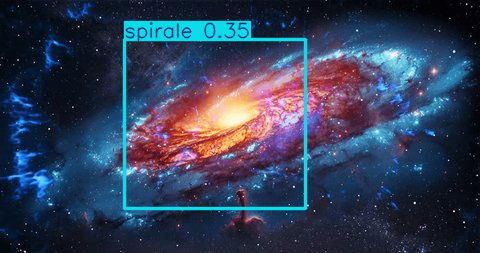

In [ ]:
import cv2
import os
from google.colab.patches import cv2_imshow
from ultralytics import YOLO

# Chemin de l'image a tester (a modifier selon ton fichier)
image_path = '/content/sky.jpg'
model_path = '/content/drive/MyDrive/Spatial/galaxy_model_v2_expert.pt'

if not os.path.exists(model_path):
    print("ERREUR : Modele expert introuvable sur le Drive.")
elif not os.path.exists(image_path):
    print(f"ERREUR : Fichier introuvable a l'emplacement : {image_path}")
else:
    model = YOLO(model_path)
    # On utilise conf=0.20 pour un bon equilibre precision/sensibilite
    results = model.predict(source=image_path, conf=0.20)

    if len(results[0].boxes) > 0:
        print(f"Succes : {len(results[0].boxes)} galaxie(s) detectee(s).")
        res_plotted = results[0].plot()
        cv2_imshow(res_plotted)
    else:
        print("Aucune galaxie detectee. L'image est peut-etre trop differente de l'entrainement.")
        cv2_imshow(cv2.imread(image_path))

In [1]:
import cv2
import requests
import numpy as np
import os
from google.colab.patches import cv2_imshow
from ultralytics import YOLO

# Liste des images a tester
urls = [
    "https://upload.wikimedia.org/wikipedia/commons/thumb/d/db/Messier51_sRGB.jpg/1200px-Messier51_sRGB.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/thumb/c/c5/M101_hires_STScI-PRC2006-10a.jpg/1200px-M101_hires_STScI-PRC2006-10a.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/c/cf/Black_hole_-_Messier_87.jpg"
]

model_path = '/content/drive/MyDrive/Spatial/galaxy_model_v2_expert.pt'
headers = {'User-Agent': 'Mozilla/5.0'}

if not os.path.exists(model_path):
    print("ERREUR : Modele expert introuvable.")
else:
    model = YOLO(model_path)

    for i, url in enumerate(urls):
        print(f"\n--- Analyse Image {i+1} ---")
        img_temp = f'image_internet_{i}.jpg'

        try:
            resp = requests.get(url, headers=headers, timeout=10)
            if resp.status_code == 200:
                with open(img_temp, 'wb') as f:
                    f.write(resp.content)

                results = model.predict(source=img_temp, conf=0.20, verbose=False)

                if len(results[0].boxes) > 0:
                    print(f"Trouve : {len(results[0].boxes)} objet(s).")
                    cv2_imshow(results[0].plot())
                else:
                    print("Rien detecte sur cette URL.")
            else:
                print(f"Echec du telechargement (Code {resp.status_code})")
        except Exception as e:
            print(f"Erreur sur l'URL {i} : {e}")

ModuleNotFoundError: No module named 'ultralytics'